In [1]:
# system level
import sys
import json

# arrays
import numpy as np
from numpy import random

# keras
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense, Activation, Dropout, merge
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.models import model_from_json
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

# sklearn (for machine learning)
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# plotting
from matplotlib import pyplot as plt
import pylab as pl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import seaborn as sns

% matplotlib inline


Using TensorFlow backend.
UsageError: Line magic function `%` not found.


In [2]:
# utility plots
def remove_tick_labels(axis):
    """Remove tick labels."""
    axis.set_xticklabels([])
    axis.set_yticklabels([])

    for tl in axis.xaxis.get_major_ticks():
        tl.tick1On = tl.tick2On = False
    for tl in axis.yaxis.get_major_ticks():
        tl.tick1On = tl.tick2On = False

def make_mosaic(imgs, nrows, ncols, border=1):
    """Make a nice mosaic.

    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols;
    intended for use with activation layer
    """
    # set up data
    nimgs = imgs.shape[0]
    imshape = imgs.shape#[1:]
    print(nimgs, imgs.shape, imshape)

    mosaic = np.ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                           ncols * imshape[1] + (ncols - 1) * border),
                           dtype=np.float32)

    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
#it used to write xrange(nimgs) but it reported an error since I have Python 3    
    for i in range(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols

        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None, norm=None):
    """Image plot."""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    remove_tick_labels(ax)
    im = ax.imshow(data, vmin=vmin, vmax=vmax,
                   #interpolation='nearest',
                   cmap=cmap,
                   norm=norm)
    plt.colorbar(im, cax=cax)

def get_layers(model, data,
                 version_data,
                 ind_layer_in=0,
                 ind_layer_out=0):
    """Recall activation layer information."""
    data_sets = {"train": 0, "test": 1}
    layer_input = model.layers[ind_layer_in].input
    layer_output = K.function([layer_input, K.learning_phase()],
                              [model.layers[ind_layer_out].output])
    layer_outputs = layer_output([data, data_sets[version_data]])[0]

    return layer_outputs    
    
def plot_layer_filter_panel(
                             layer,
                             ind_obj_choice,
                             n_img_y=6,
                             n_img_x=6):
                             
    """Plot: result of a layer; all filters."""
    # style
    #plt.style.use(dir_style + 'deeplensing.mplstyle')
    sns.set_palette("coolwarm", n_colors=6)
    n_colors = 300
    cmap = sns.color_palette("coolwarm", n_colors=n_colors)#, color_codes=True)
    cmap = ListedColormap(cmap)

    layer_object = layer[ind_obj_choice]
    # layer_object = layer_object + np.abs(np.min(layer_object))+1.0
    c1 = np.squeeze(layer_object)

    # plot
    plt.figure(figsize=(12, 12))
    plt.grid(False)
    nice_imshow(plt.gca(), make_mosaic(c1, n_img_x, n_img_y), vmin=-120, vmax=40, cmap=cmap)#, norm=LogNorm())
    return

In [2]:
# ------------------------------------------------------------------------------
# Input variables
# ------------------------------------------------------------------------------

# training variables
# 70:10:20 for training:valid:test
nb_train = 10799
nb_valid = 1542
nb_test = 3085
nb_epoch = 250
nb_classes = 2
batch_size = 32
shuffle = True

# data locations
dir_test = "model/"
file_x_data = "SB00_RF_68_augmented.npy" # x data (images)
file_y_data = "SB00_RF_y_68_augmented.npy" # y data (labels)
#file_lens_data = dir_test + "lenspars_set.npy" # lens data (physical parameters of lenses/non-lenses)
f_model = dir_test + "SB00_model_68_4.json" # model data (architecture)
f_weights = dir_test + "SB00_weights_68_4.h5" # model data (weights that we fit for)
f_history = dir_test + "SB00_history_68_4.json"
f_best_weights = dir_test + "SB0_best_weights_68_4.h5"

merg_sub = "SB25_RF_merger_notmerger_y_with_subsamples_augmented_68.npy" #file which contains pre and post merger subsample
subid_load = "SB25_RF_merger_notmerger_SUBID_for_subsamples_augmented_68.npy"#file with all suids after augmentation

cc_load = "SB25_RF_augmented_68_cc.npy" #concentration
m20_load = "SB25_RF_augmented_68_m20.npy" #M20

In [3]:
# load data, all filters
x_data = np.load(file_x_data)
y_data = np.load(file_y_data)
y_sub = np.load(merg_sub)
subids = np.load(subid_load)

cc = np.load(cc_load)
m20 = np.load(m20_load)

In [4]:
len(y_sub)

15426

In [4]:
# ------------------------------------------------------------------------------
# Read in Data
# ------------------------------------------------------------------------------


#every day we shufflin
random.seed(0)
idx = np.random.choice(len(x_data), size=len(x_data), replace=False)
x_data = x_data[idx]
y_data = y_data[idx]
y_sub_data = y_sub[idx]
subid = subids[idx]
cc = cc[idx]
m20 = m20[idx]


# check data sizes
statement =  "#TrainingSamples + #ValidSamples #TestSamples > TotalSamples, exiting!!!"
nb_total = nb_train + nb_test + nb_valid
assert nb_total <= len(x_data), statement

# indices for where to slice the arrays
ind_valid_start = ind_train_end = nb_train
ind_valid_end = ind_test_start = nb_train + nb_valid
ind_test_end = nb_train + nb_valid + nb_test

# slice the image arrays
x_train = x_data[:ind_train_end, :, :, :]
x_valid = x_data[ind_valid_start: ind_valid_end, :, :, :]
x_test = x_data[ind_test_start: ind_test_end, :, :, :]

# slice the label arrays
y_train = y_data[:ind_train_end]
y_valid = y_data[ind_valid_start: ind_valid_end]
y_test = y_data[ind_test_start: ind_test_end]

# slice the subsample arrays
y_sub_train = y_sub_data[:ind_train_end]
y_sub_valid = y_sub_data[ind_valid_start: ind_valid_end]
y_sub_test = y_sub_data[ind_test_start: ind_test_end]

#slice subids
subid_train = subid[:ind_train_end]
subid_valid = subid[ind_valid_start: ind_valid_end]
subid_test = subid[ind_test_start: ind_test_end]

#slice cc
cc_train = cc[:ind_train_end]
cc_valid = cc[ind_valid_start: ind_valid_end]
cc_test = cc[ind_test_start: ind_test_end]


#slice m20
m20_train = m20[:ind_train_end]
m20_valid = m20[ind_valid_start: ind_valid_end]
m20_test = m20[ind_test_start: ind_test_end]

# cast data types
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')


print( "Data dimensions: ")
print( "Input data: ", np.shape(x_data), np.shape(y_data), "and subsample array:", np.shape(y_sub_data))
print( "Training set: ", np.shape(x_train), np.shape(y_train), "and subsample array:", np.shape(y_sub_train))
print( "Validation set: ", np.shape(x_valid), np.shape(y_valid),"and subsample array:", np.shape(y_sub_valid))
print( "Test Set: ", np.shape(x_test), np.shape(y_test), "and subsample array:", np.shape(y_sub_test))

print("Subid input",np.shape(subid),"Subid train:",np.shape(subid_train),"Subid validation:",np.shape(subid_valid),"Subid test:",np.shape(subid_test))

print("Concentration input",np.shape(cc),"CC train:",np.shape(cc_train),"CC validation:",np.shape(cc_valid),"CC test:",np.shape(cc_test))
print("M20 input",np.shape(m20),"M20 train:",np.shape(m20_train),"M20 validation:",np.shape(m20_valid),"M20 test:",np.shape(m20_test))

Data dimensions: 
Input data:  (15426, 2, 75, 75) (15426,) and subsample array: (15426, 3)
Training set:  (10799, 2, 75, 75) (10799,) and subsample array: (10799, 3)
Validation set:  (1542, 2, 75, 75) (1542,) and subsample array: (1542, 3)
Test Set:  (3085, 2, 75, 75) (3085,) and subsample array: (3085, 3)
Subid input (15426,) Subid train: (10799,) Subid validation: (1542,) Subid test: (3085,)
Concentration input (15426,) CC train: (10799,) CC validation: (1542,) CC test: (3085,)
M20 input (15426,) M20 train: (10799,) M20 validation: (1542,) M20 test: (3085,)


In [6]:
# ------------------------------------------------------------------------------
# generate the model architecture
# example: shallow res (enter link to reference)
# Alex: rewritten for Keras 2
# ------------------------------------------------------------------------------

# Define architecture for model
data_shape = np.shape(x_data)
input_shape = (2, 75, 75)
x = Input(shape=input_shape)
c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same', data_format='channels_first')(x)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
e0 = Dropout(0.5)(d0)



c1 = Convolution2D(15, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
e1 = Dropout(0.5)(d1)


c2 = Convolution2D(30, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
e2 = Dropout(0.5)(d2)


f = Flatten()(e2)
z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
y = Dense(1, activation='sigmoid')(z1)

model = Model(inputs=x, outputs=y)

# Compile Model
optimizer = 'adam'
metrics = ['accuracy']
loss = 'binary_crossentropy'
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2, 75, 75)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 75, 75)         408       
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 75, 75)         300       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 37, 75)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 37, 75)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 37, 15)         10140     
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 37, 15)         60        
__________

In [12]:
# ------------------------------------------------------------------------------
# Train model
# ------------------------------------------------------------------------------
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50),
     ModelCheckpoint(f_best_weights, monitor='val_acc', mode='max', verbose=1, save_best_only=True)]

# Train 
history = model.fit(
                    x_train, y_train,
                    batch_size=batch_size,
                    epochs=nb_epoch,
                    validation_data=(x_valid, y_valid),                
                    #shuffle=shuffle,
                    verbose=True,
                    callbacks=es
                    )
# Save data
model.save_weights(f_weights, overwrite=True)
open(f_model, 'w').write(model.to_json())

#Saving history for future use

with open(f_history, 'w') as f:
    json.dump(history.history, f)

Train on 10799 samples, validate on 1542 samples
Epoch 1/250
10799/10799 [==============================] - 73s 7ms/step - loss: 0.6942 - acc: 0.5215 - val_loss: 0.6899 - val_acc: 0.5383

Epoch 00001: val_acc improved from -inf to 0.53826, saving model to model/SB0_best_weights_68_4.h5
Epoch 2/250
10799/10799 [==============================] - 73s 7ms/step - loss: 0.6871 - acc: 0.5213 - val_loss: 0.6833 - val_acc: 0.5396

Epoch 00002: val_acc improved from 0.53826 to 0.53956, saving model to model/SB0_best_weights_68_4.h5
Epoch 3/250
10799/10799 [==============================] - 73s 7ms/step - loss: 0.6754 - acc: 0.6200 - val_loss: 0.6751 - val_acc: 0.5649

Epoch 00003: val_acc improved from 0.53956 to 0.56485, saving model to model/SB0_best_weights_68_4.h5
Epoch 4/250
10799/10799 [==============================] - 73s 7ms/step - loss: 0.6634 - acc: 0.6352 - val_loss: 0.6880 - val_acc: 0.5460

Epoch 00004: val_acc did not improve from 0.56485
Epoch 5/250
10799/10799 [=================


Epoch 00082: val_acc did not improve from 0.76719
Epoch 83/250
10799/10799 [==============================] - 74s 7ms/step - loss: 0.5084 - acc: 0.7540 - val_loss: 0.4983 - val_acc: 0.7613

Epoch 00083: val_acc did not improve from 0.76719
Epoch 84/250
10799/10799 [==============================] - 74s 7ms/step - loss: 0.5186 - acc: 0.7503 - val_loss: 0.4950 - val_acc: 0.7607

Epoch 00084: val_acc did not improve from 0.76719
Epoch 85/250
10799/10799 [==============================] - 73s 7ms/step - loss: 0.5149 - acc: 0.7536 - val_loss: 0.4896 - val_acc: 0.7698

Epoch 00085: val_acc improved from 0.76719 to 0.76978, saving model to model/SB0_best_weights_68_4.h5
Epoch 86/250
10799/10799 [==============================] - 74s 7ms/step - loss: 0.5119 - acc: 0.7535 - val_loss: 0.5061 - val_acc: 0.7497

Epoch 00086: val_acc did not improve from 0.76978
Epoch 87/250
10799/10799 [==============================] - 74s 7ms/step - loss: 0.5083 - acc: 0.7551 - val_loss: 0.4915 - val_acc: 0.759

In [32]:
# seraching for examples
for i in range(len(y_test)):
    if (y_test[i] == 0 and pred[i,0] == 1):
        print (i)
        print(y_test[i],pred[i])

3
0.0 [1]
17
0.0 [1]
29
0.0 [1]
30
0.0 [1]
51
0.0 [1]
62
0.0 [1]
76
0.0 [1]
80
0.0 [1]
81
0.0 [1]
90
0.0 [1]
95
0.0 [1]
122
0.0 [1]
123
0.0 [1]
138
0.0 [1]
160
0.0 [1]
163
0.0 [1]
169
0.0 [1]
171
0.0 [1]
172
0.0 [1]
193
0.0 [1]
201
0.0 [1]
206
0.0 [1]
207
0.0 [1]
211
0.0 [1]
214
0.0 [1]
227
0.0 [1]
232
0.0 [1]
234
0.0 [1]
244
0.0 [1]
251
0.0 [1]
256
0.0 [1]
259
0.0 [1]
276
0.0 [1]
279
0.0 [1]
282
0.0 [1]
293
0.0 [1]
296
0.0 [1]
307
0.0 [1]
345
0.0 [1]
348
0.0 [1]
350
0.0 [1]
351
0.0 [1]
384
0.0 [1]
396
0.0 [1]
404
0.0 [1]
413
0.0 [1]
422
0.0 [1]
427
0.0 [1]
438
0.0 [1]
450
0.0 [1]
452
0.0 [1]
454
0.0 [1]
488
0.0 [1]
497
0.0 [1]
502
0.0 [1]
505
0.0 [1]
521
0.0 [1]
532
0.0 [1]
538
0.0 [1]
545
0.0 [1]
566
0.0 [1]
590
0.0 [1]
600
0.0 [1]
609
0.0 [1]
611
0.0 [1]
613
0.0 [1]
625
0.0 [1]
687
0.0 [1]
711
0.0 [1]
717
0.0 [1]
740
0.0 [1]
748
0.0 [1]
762
0.0 [1]
788
0.0 [1]
796
0.0 [1]
797
0.0 [1]
802
0.0 [1]
804
0.0 [1]
805
0.0 [1]
828
0.0 [1]
833
0.0 [1]
834
0.0 [1]
836
0.0 [1]
844
0.0 [1]
845


In [34]:
print(prob[87],prob[1370],prob[2053],prob[3007])
print(prob[538],prob[1216],prob[2900],prob[3021])
print(prob[553],prob[1052],prob[2486],prob[3082])
print(prob[462],prob[1530],prob[2246],prob[3075])

[0.8487288] [0.9209998] [0.91972667] [0.7974363]
[0.56786805] [0.7042929] [0.8886148] [0.8360143]
[0.29737967] [0.1432343] [0.22385077] [0.16375233]
[0.31710902] [0.38464418] [0.24922466] [0.32039496]


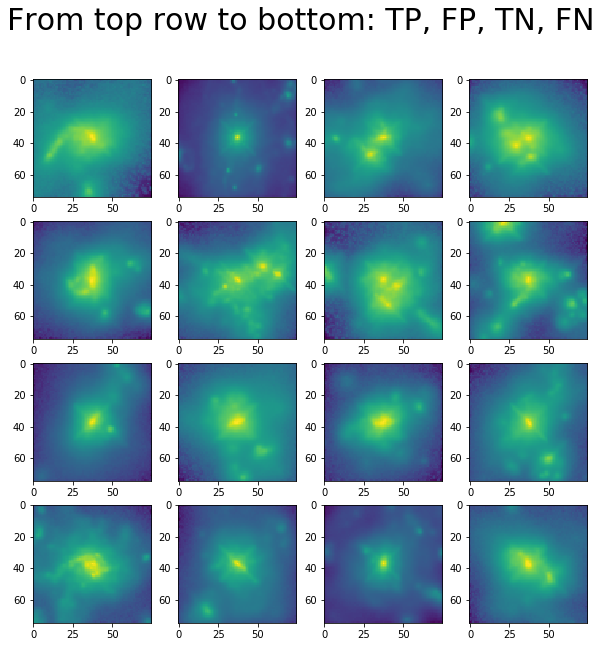

In [39]:
#some example plot from TP,FP,TN and FN
tp1 = x_test[87,1]
tp2 = x_test[1370,1]
tp3 = x_test[2053,1]
tp4 = x_test[3007,1]

fp1 = x_test[538,1]
fp2 = x_test[1216,1]
fp3 = x_test[2900,1]
fp4 = x_test[3021,1]

tn1 = x_test[553,1]
tn2 = x_test[1052,1]
tn3 = x_test[2486,1]
tn4 = x_test[3082,1]

fn1 = x_test[462,1]
fn2 = x_test[1530,1]
fn3 = x_test[2246,1]
fn4 = x_test[3075,1]

examples = [tp1, tp2, tp3, tp4, fp1, fp2, fp3, fp4, tn1, tn2, tn3, tn4, fn1, fn2, fn3, fn4]
figm = plt.figure(figsize=(10,10))

for i in range(0,16):
    figm.suptitle('From top row to bottom: TP, FP, TN, FN', fontsize=30)
    ym = figm.add_subplot(4,4,i+1)
    ym.imshow(examples[i],norm=LogNorm())
    plt.grid(False)
#figm.suptitle('TP', fontsize=30)
plt.show()
#figm.savefig('SB00_TP_FP_TN_FN_examples_68.jpg')

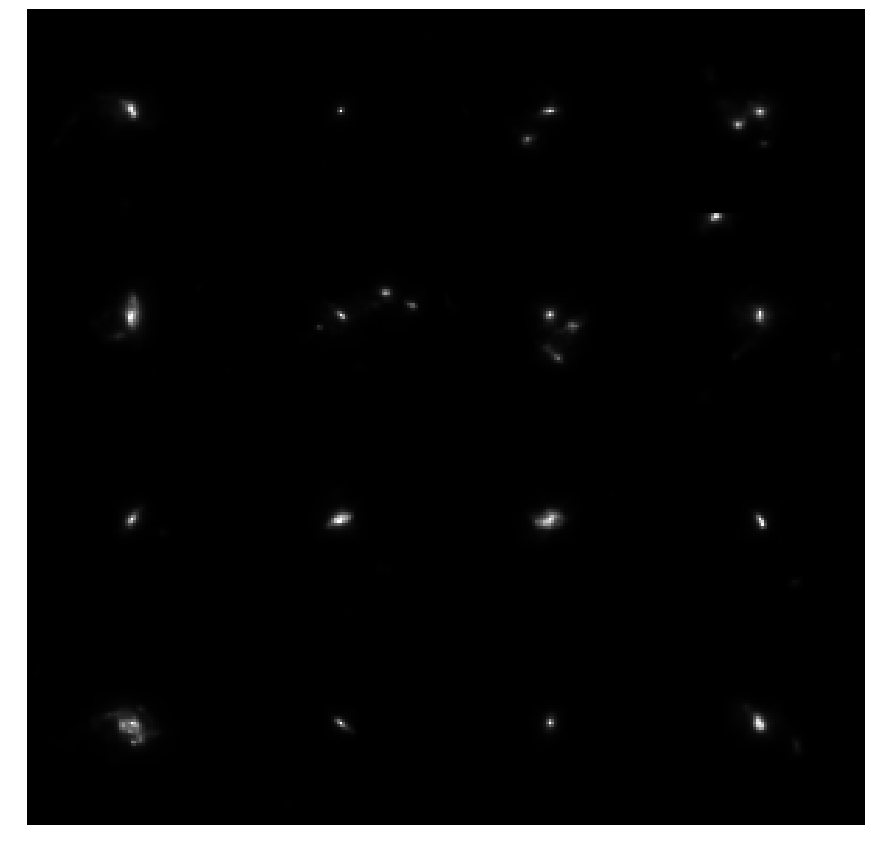

In [38]:
fig1=plt.figure(figsize=(15,15))
for i, image in enumerate(examples):
    plt.subplot(4, 4, i + 1)
    plt.axis("off")
    plt.imshow(image, aspect='auto', cmap='gray')#norm=LogNorm()
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()
fig1.savefig('FINAL_SB00_TP_FP_TN_FN_examples_tight_LOG_JET.eps')

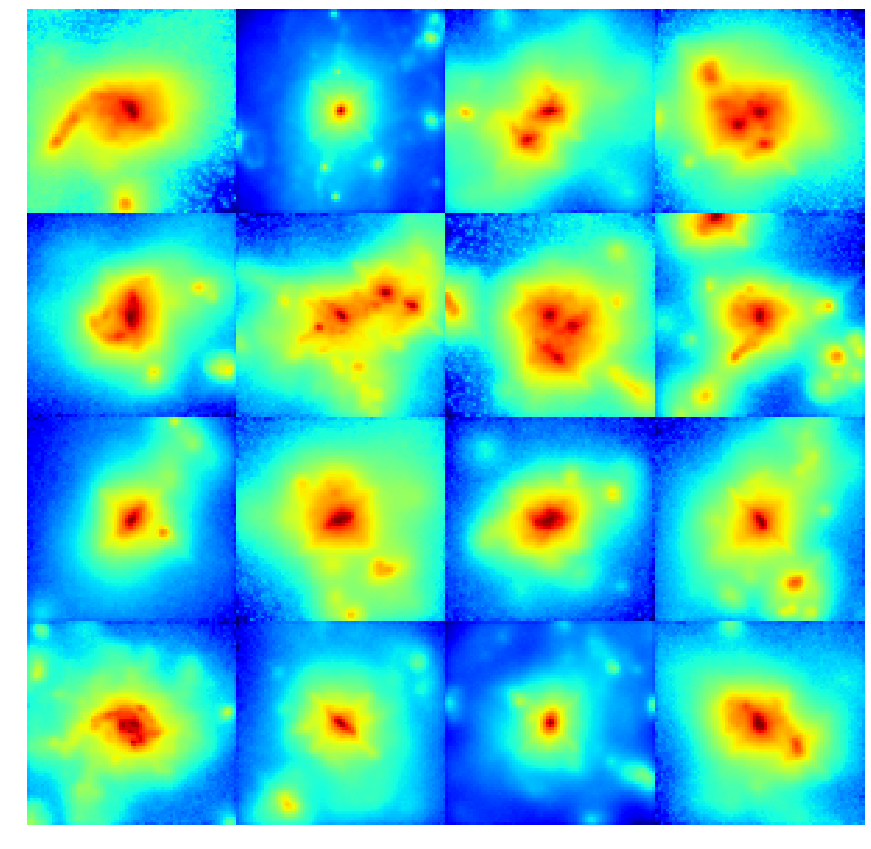

In [41]:
probs = [prob[87].tolist(),prob[1370].tolist(),prob[2053].tolist(),prob[3007].tolist(),
         prob[538].tolist(),prob[1216].tolist(),prob[2900].tolist(),prob[3021].tolist(),
         prob[553].tolist(),prob[1052].tolist(),prob[2486].tolist(),prob[3082].tolist(),
         prob[462].tolist(),prob[1530].tolist(),prob[2246].tolist(),prob[3075].tolist()]
probs = list(np.array(probs).flat)

fig1=plt.figure(figsize=(15,15))

for i, image in enumerate(examples):
    plt.subplot(4, 4, i + 1)
    plt.axis("off")
    plt.imshow(image, aspect='auto', cmap='jet', norm=LogNorm())
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()
fig1.savefig('FINAL_SB00_TP_FP_TN_FN_examples_tight_LOG_JET_68.pdf')

In [28]:
#loading history
#not needed any more

import codecs
import os

path = 'model/SB00_history_68_4.json'
if os.path.exists(path): # reload history if it exists
        with codecs.open(path, 'r', encoding='utf-8') as f:
             n = json.loads(f.read())
                
#LOADING MODEL


json_file = open(f_model, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [14]:
# evaluate loaded model on test data

loaded_model.load_weights(f_weights)
# load weights into new model
print("Loaded model from disk")

loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(x_test, y_test, verbose=True)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

3085/3085 [==============================] - 10s 3ms/step
acc: 72.03%


In [29]:
# load best weights into new model
loaded_model.load_weights(f_best_weights)
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(x_test, y_test, verbose=True)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
3085/3085 [==============================] - 10s 3ms/step
acc: 77.28%


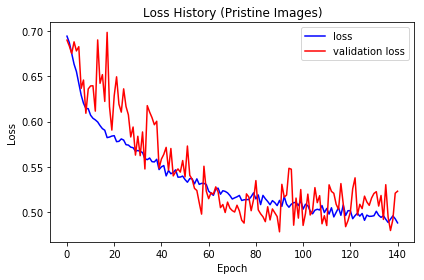

In [9]:
#plotting from history

#LOSS
loss=n['loss']
val_loss=n['val_loss']
epochs = list(range(len(loss)))
#epochs = epochs[:90]
#loss = loss[:90]
#val_loss = val_loss[:90]
figsize=(6,4)
fig, axis1 = plt.subplots(figsize=figsize)
plot1_loss = axis1.plot(epochs, loss, 'b', label='loss')
plot1_val_loss = axis1.plot(epochs, val_loss, 'r', label="validation loss")
plots = plot1_loss + plot1_val_loss
labs = [l.get_label() for l in plots]
axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss')
plt.title("Loss History (Pristine Images)")
plt.tight_layout()
axis1.legend(loc='upper right')
pl.savefig('FINAL_SB00_loss_68_4.pdf')

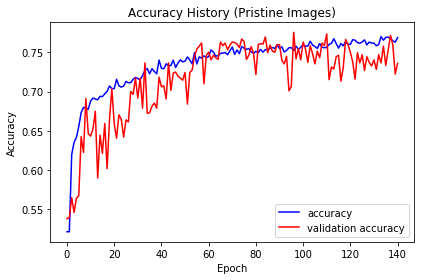

In [11]:
#ACCURACY
acc=n['acc']
val_acc=n['val_acc']
epochs = list(range(len(acc)))
figsize=(6,4)
fig, axis1 = plt.subplots(figsize=figsize)
plot1_loss = axis1.plot(epochs, acc, 'b', label='accuracy')
plot1_val_loss = axis1.plot(epochs, val_acc, 'r', label="validation accuracy")
plots = plot1_loss + plot1_val_loss
labs = [l.get_label() for l in plots]
axis1.set_xlabel('Epoch')
axis1.set_ylabel('Accuracy')
plt.title("Accuracy History (Pristine Images)")
plt.tight_layout()
axis1.legend(loc='lower right')
pl.savefig('FINAL_SB00_acc_68_4.pdf')

In [53]:
val_acc.index(max(val_acc))

96

In [54]:
max(val_acc)

0.7756160830090791

In [55]:
val_acc[93:98]

[0.745136186770428,
 0.7010376134116671,
 0.7068741892871535,
 0.7756160830090791,
 0.74189364461738]

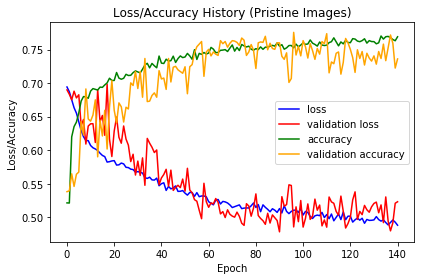

In [48]:
#plotting from history loss and accuracy combined

#LOSS
loss=n['loss']
val_loss=n['val_loss']
acc=n['acc']
val_acc=n['val_acc']

epochs = list(range(len(loss)))
figsize=(6,4)
fig, axis1 = plt.subplots(figsize=figsize)
plot1_loss = axis1.plot(epochs, loss, 'b', label='loss')
plot1_val_loss = axis1.plot(epochs, val_loss, 'r', label="validation loss")

plot1_lacc = axis1.plot(epochs, acc, 'green', label='accuracy')
plot1_val_lacc = axis1.plot(epochs, val_acc, 'orange', label="validation accuracy")

plots = plot1_loss + plot1_val_loss
labs = [l.get_label() for l in plots]
axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/Accuracy')
plt.title("Loss/Accuracy History (Pristine Images)")
plt.tight_layout()
axis1.legend(loc='center right')
pl.savefig('FINAL_loss_acc_00_68_4.pdf')

cm [[1076.  351.]
 [ 350. 1308.]]
cm_norm [[0.75402943 0.24597057]
 [0.21109771 0.78890229]]
AUC: 0.8505694925455395


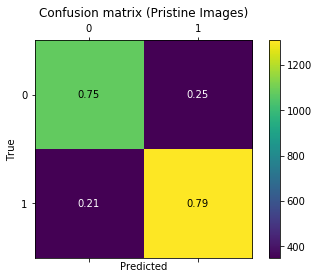

In [30]:
# ------------------------------------------------------------------------------
# Evaluate for TEST SET
# ------------------------------------------------------------------------------
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# predict
prob = loaded_model.predict(x_test)
pred =  (prob > 0.5).astype('int32') 

# measure confusion
labels=[0, 1]
cm = metrics.confusion_matrix(y_test, pred, labels=labels)
cm = cm.astype('float')
cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]
print("cm", cm)
print("cm_norm", cm_norm)

fpr, tpr, thresholds = metrics.roc_curve(y_test, prob, pos_label=1)
auc = metrics.roc_auc_score(y_test, prob)
print("AUC:", auc)

#plotting
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix (Pristine Images)',y=1.08)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
fmt = '.2f'
thresh = cm_norm.max() / 2.
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(j, i, format(cm_norm[i, j], fmt),
        ha="center", va="center",
        color="white" if cm_norm[i, j] < thresh else "black")
pl.savefig('FINAL_SB00_Conf_Matrix_TEST_68_4.pdf')
plt.show()

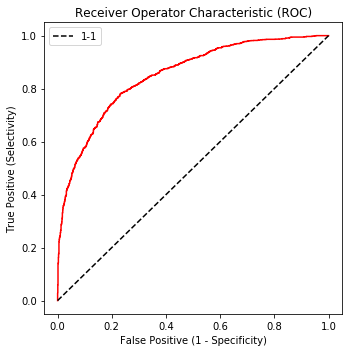

In [15]:
# ROC TEST SET
figsize=(5,5)
fig, axis1 = plt.subplots(figsize=figsize)
x_onetoone = y_onetoone = [0, 1]
#label_roc = "ROC, AUC = " + auc if auc is not None else "ROC"
plt.plot(fpr, tpr, 'r-')#,  label=label_roc)
plt.plot(x_onetoone, y_onetoone, 'k--',  label="1-1")
plt.legend(loc=0)
plt.title("Receiver Operator Characteristic (ROC)")
plt.xlabel("False Positive (1 - Specificity)")
plt.ylabel("True Positive (Selectivity)")
plt.tight_layout()
pl.savefig('FINAL_SB00_ROC_TEST_bestweights_68_4.pdf')

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, pred)
print('F1 score: %f' % f1)

Accuracy: 0.772771
Precision: 0.788427
Recall: 0.788902
F1 score: 0.788664


In [ ]:
# plots with subsamlpes

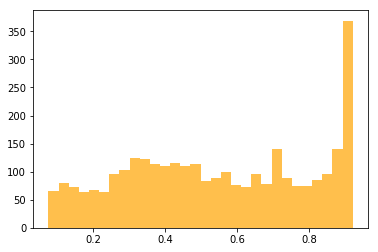

In [21]:
#import numpy as np
#import matplotlib.pyplot as plt

xx = prob
num_bins = 30
n, bins, patches = plt.hist(xx, num_bins, facecolor='orange', alpha=0.7)
plt.show()

In [17]:
#make subsamples for plotting
list_pre = []
list_post = []
list_nonmerger = []
for i in range(len(y_sub_test)):
    if y_sub_test[i,0]==1 and y_sub_test[i,1]==1:
        list_pre.append(prob[i])
    if y_sub_test[i,0]==1 and y_sub_test[i,1]==0:
        list_post.append(prob[i])
    if y_sub_test[i,0]==0:
        list_nonmerger.append(prob[i])
pre = np.stack(list_pre)
post = np.stack(list_post)
non = np.stack(list_nonmerger)

In [18]:
print('pre:',len(pre) ,'post:',len(post),'\n summ:',len(pre)+len(post))
print('nonmergers:',len(non))

pre: 1272 post: 386 
 summ: 1658
nonmergers: 1427


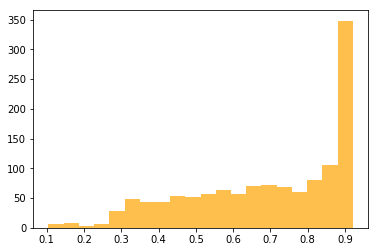

In [19]:
x1 = pre
num_bins = 20
n, bins, patches = plt.hist(x1, num_bins, facecolor='orange', alpha=0.7)
plt.show()

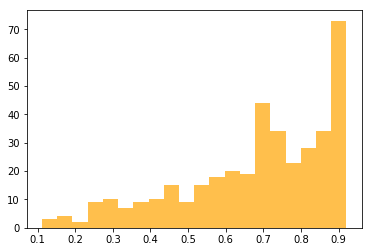

In [20]:
x2 = post
num_bins = 20
n, bins, patches = plt.hist(x2, num_bins, facecolor='orange', alpha=0.7)
plt.show()

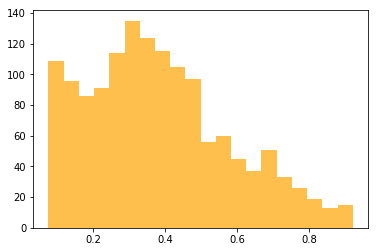

In [21]:
x3 = non
num_bins = 20
n, bins, patches = plt.hist(x3, num_bins, facecolor='orange', alpha=0.7)
plt.show()

TEST SET OF PRISTINE IMAGES SB00
Number of pre-mergers: 1272 
Number of post-mergers: 386 
Number of nonmergers: 1427


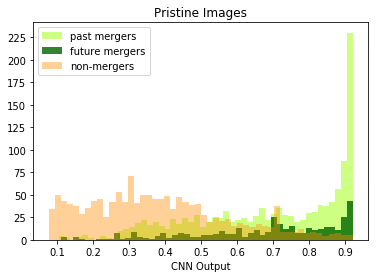

In [52]:
print('TEST SET OF PRISTINE IMAGES SB00\n' 'Number of pre-mergers:',len(pre) ,'\nNumber of post-mergers:',len(post),'\nNumber of nonmergers:',len(non))
bins = 50
plt.hist(x1, bins, alpha=0.6, label='past mergers', color='greenyellow')
plt.hist(x2, bins, alpha=0.8, label='future mergers', color='darkgreen')
plt.hist(x3, bins, alpha=0.4, label='non-mergers', color='darkorange')
plt.legend(loc='upper left')#,bbox_to_anchor=(0.9, 1))
plt.xticks(np.arange(0.1, 1, step=0.1))
plt.yticks(np.arange(0, 250, step=25))
plt.title("Pristine Images")
plt.xlabel("CNN Output")
plt.savefig('FINAL_Histogram_SB00_68_4.pdf')
plt.show()

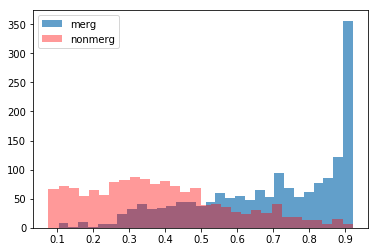

In [64]:
merg = np.concatenate((pre, post))
bins = 30
plt.hist(merg, bins, alpha=0.7, label='merg')
plt.hist(x3, bins, alpha=0.4, label='nonmerg', color='red')
plt.xticks(np.arange(0.1, 1, step=0.1))
plt.legend(loc='upper left')
#plt.savefig('Histogram_SB00_68_4.jpg')
plt.show()

In [ ]:
#morphology study

In [24]:
#make subsamples for plotting
list_pre_subid = []
list_post_subid = []
list_nonmerger_subid = []


cc_pre_list = []
cc_post_list = []
cc_non_list = []

m20_pre_list = []
m20_post_list = []
m20_non_list = []


for i in range(len(y_sub_test)):
    if y_sub_test[i,0]==1 and y_sub_test[i,1]==1:
        list_pre_subid.append(subid_test[i])
        cc_pre_list.append(cc_test[i])
        m20_pre_list.append(m20_test[i])
    if y_sub_test[i,0]==1 and y_sub_test[i,1]==0:
        list_post_subid.append(subid_test[i])
        cc_post_list.append(cc_test[i])
        m20_post_list.append(m20_test[i])
    if y_sub_test[i,0]==0:
        list_nonmerger_subid.append(subid_test[i])
        cc_non_list.append(cc_test[i])
        m20_non_list.append(m20_test[i])
        
pre_subid = np.stack(list_pre_subid)
post_subid = np.stack(list_post_subid)
non_subid = np.stack(list_nonmerger_subid)

cc_pre = np.stack(cc_pre_list)
cc_post = np.stack(cc_post_list)
cc_non = np.stack(cc_non_list)

m20_pre = np.stack(m20_pre_list)
m20_post = np.stack(m20_post_list)
m20_non = np.stack(m20_non_list)

In [34]:
print('pre:',len(pre_subid),'post:',len(post_subid),'\n summ:',len(pre_subid)+len(post_subid))
print('nonmergers:',len(non_subid))

pre: 1272 post: 386 
 summ: 1658
nonmergers: 1427


In [35]:
print('pre:',len(cc_pre),'post:',len(cc_post),'\n summ:',len(cc_pre)+len(cc_post))
print('nonmergers:',len(cc_non),'\n')

print('pre:',len(cc_pre),'post:',len(cc_post),'\n summ:',len(cc_pre)+len(cc_post))
print('nonmergers:',len(cc_non))

pre: 1272 post: 386 
 summ: 1658
nonmergers: 1427 

pre: 1272 post: 386 
 summ: 1658
nonmergers: 1427


In [ ]:
#np.save('past_mergers_subid.npy',pre_subid)
#np.save('future_mergers_subid.npy',post_subid)
#np.save('nonmergers_subid.npy',non_subid)

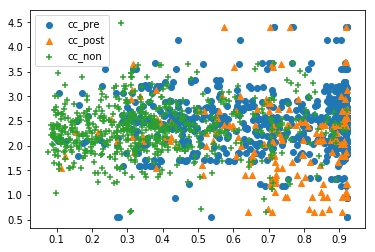

In [25]:
plt.scatter(pre, cc_pre,marker='o',label='cc_pre')
plt.scatter(post, cc_post,marker='^',label='cc_post')
plt.scatter(non, cc_non,marker='+',label='cc_non')
plt.xticks(np.arange(0.1, 1, step=0.1))
plt.legend(loc='upper left')
plt.show()

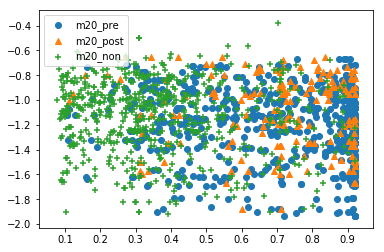

In [27]:
plt.scatter(pre, m20_pre,marker='o', label='m20_pre')
plt.scatter(post, m20_post,marker='^',label='m20_post')
plt.scatter(non, m20_non,marker='+',label='m20_non')
plt.xticks(np.arange(0.1, 1, step=0.1))
plt.legend(loc='upper left')
plt.show()

/home/aleksandra/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/aleksandra/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


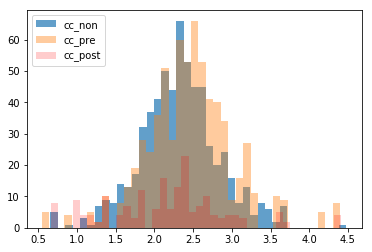

In [32]:
bins = 40
plt.hist(cc_non, bins, alpha=0.7, label='cc_non')
plt.hist(cc_pre, bins, alpha=0.4, label='cc_pre')
plt.hist(cc_post, bins, alpha=0.2, label='cc_post', color='red')
plt.legend(loc='upper left')
#plt.savefig('Histogram_SB25_68.jpg')
plt.show()

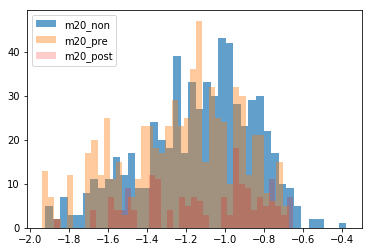

In [33]:
bins = 40
plt.hist(m20_non, bins, alpha=0.7, label='m20_non')
plt.hist(m20_pre, bins, alpha=0.4, label='m20_pre')
plt.hist(m20_post, bins, alpha=0.2, label='m20_post', color='red')
plt.legend(loc='upper left')
#plt.savefig('Histogram_SB25_68.jpg')
plt.show()

In [ ]:
#lets import SB25 model and try to clasisfy pristine images with it

In [63]:
f_model = dir_test + "model_25_68_4.json" # model data (architecture)
f_weights = dir_test + "weights_25_68_4.h5" # model data (weights that we fit for)
f_history = dir_test + "history_25_68_4.json"
f_best_weights = dir_test + "best_weights_68_4.h5"

In [64]:
#LOADING MODEL


json_file = open(f_model, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load best weights into new model
loaded_model.load_weights(f_best_weights)
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(x_test, y_test, verbose=True)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
3085/3085 [==============================] - 10s 3ms/step
acc: 73.94%


cm [[ 994.  433.]
 [ 371. 1287.]]
cm_norm [[0.69656622 0.30343378]
 [0.22376357 0.77623643]]
AUC: 0.8171182510653153


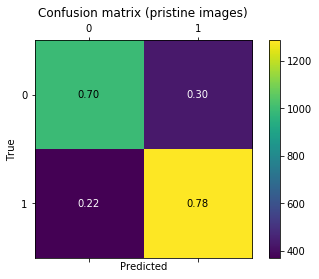

In [65]:
# ------------------------------------------------------------------------------
# Evaluate for TEST SET
# ------------------------------------------------------------------------------
# predict
prob = loaded_model.predict(x_test)
pred =  (prob > 0.5).astype('int32') 

# measure confusion
labels=[0, 1]
cm = metrics.confusion_matrix(y_test, pred, labels=labels)
cm = cm.astype('float')
cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]
print("cm", cm)
print("cm_norm", cm_norm)

fpr, tpr, thresholds = metrics.roc_curve(y_test, prob, pos_label=1)
auc = metrics.roc_auc_score(y_test, prob)
print("AUC:", auc)

#plotting
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix (pristine images)',y=1.08)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
fmt = '.2f'
thresh = cm_norm.max() / 2.
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(j, i, format(cm_norm[i, j], fmt),
        ha="center", va="center",
        color="white" if cm_norm[i, j] < thresh else "black")
#pl.savefig('SB00_Conf_Matrix_TEST_68.jpg')
plt.show()

In [59]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, pred)
print('F1 score: %f' % f1)

Accuracy: 0.739384
Precision: 0.748256
Recall: 0.776236
F1 score: 0.761989


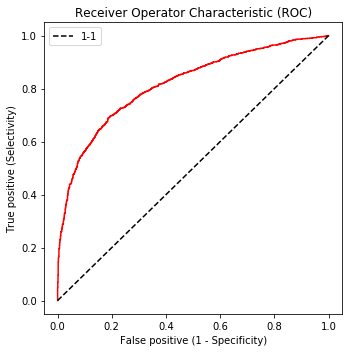

In [60]:
# ROC TEST SET
figsize=(5,5)
fig, axis1 = plt.subplots(figsize=figsize)
x_onetoone = y_onetoone = [0, 1]
#label_roc = "ROC, AUC = " + auc if auc is not None else "ROC"
plt.plot(fpr, tpr, 'r-')#,  label=label_roc)
plt.plot(x_onetoone, y_onetoone, 'k--',  label="1-1")
plt.legend(loc=0)
plt.title("Receiver Operator Characteristic (ROC)")
plt.xlabel("False positive (1 - Specificity)")
plt.ylabel("True positive (Selectivity)")
plt.tight_layout()
#pl.savefig('SB00_ROC_TEST_bestweights_68.pdf')

In [67]:
#make subsamples for plotting
list_pre = []
list_post = []
list_nonmerger = []
for i in range(len(y_sub_test)):
    if y_sub_test[i,0]==1 and y_sub_test[i,1]==1:
        list_pre.append(prob[i])
    if y_sub_test[i,0]==1 and y_sub_test[i,1]==0:
        list_post.append(prob[i])
    if y_sub_test[i,0]==0:
        list_nonmerger.append(prob[i])
pre = np.stack(list_pre)
post = np.stack(list_post)
non = np.stack(list_nonmerger)

TEST SET OF PRISTINE IMAGES SB00
Number of pre-mergers: 1272 
Number of post-mergers: 386 
Number of nonmergers: 1427


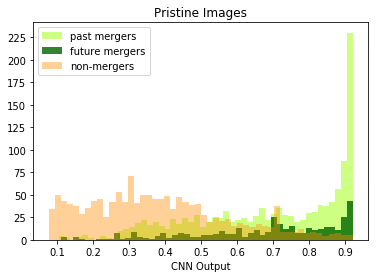

In [68]:
print('TEST SET OF PRISTINE IMAGES SB00\n' 'Number of pre-mergers:',len(pre) ,'\nNumber of post-mergers:',len(post),'\nNumber of nonmergers:',len(non))
bins = 50
plt.hist(x1, bins, alpha=0.6, label='past mergers', color='greenyellow')
plt.hist(x2, bins, alpha=0.8, label='future mergers', color='darkgreen')
plt.hist(x3, bins, alpha=0.4, label='non-mergers', color='darkorange')
plt.legend(loc='upper left')#,bbox_to_anchor=(0.9, 1))
plt.xticks(np.arange(0.1, 1, step=0.1))
plt.yticks(np.arange(0, 250, step=25))
plt.title("Pristine Images")
plt.xlabel("CNN Output")
#plt.savefig('FINAL_Histogram_SB00_68_4.pdf')
plt.show()